In [1]:
!pip install -q -U transformers peft accelerate optimum
!pip -qqq install bitsandbytes accelerate
!pip install auto-gptq

  Obtaining dependency information for auto-gptq from https://files.pythonhosted.org/packages/ba/b6/0c7fec03da337d645e407a76cdf78386d4749513e22558abc17665cdcaab/auto_gptq-0.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 81.1 MB/s eta 0:00:00


# Quantizing a pretrained GPT2 on the LAMBADA dataset with AutoGPTQ

AutoGPTQ simplifies the process of quantizing Large Language Models (LLMs) based on the GPTQ algorithm. GPTQ is a post-training quantization approach designed to quantize pretrained models efficiently, requiring only moderate resources, such as a calibration dataset and a few hours of computation.

In this experiment, we leverage the validation dataset as the calibration dataset. This subset of data is crucial for fine-tuning and aligning the quantized model's predictions with the true probabilities.

Our objective is to assess the performance of the quantized models using three different configurations. The evaluation metrics include top-k accuracy, token generation speed on the test dataset, and the size of the quantized model in megabytes.

It's important to note that the evaluation is conducted on a subset of the test set, specifically 1000 samples. This subset is chosen due to the extended execution time associated with evaluating the entire dataset. This approach allows us to efficiently gauge the quantized models' performance and make meaningful comparisons.


### Define a function for model quantization

In [2]:
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
from transformers import TextGenerationPipeline
import torch
import os
from transformers import AutoTokenizer
from datasets import load_dataset

def quantize_model(bits, model_id, quantized_model_dir, dataset):
    quantize_config = BaseQuantizeConfig(bits=bits, group_size=128)
    model = AutoGPTQForCausalLM.from_pretrained(model_id, quantize_config, torch_dtype=torch.float16)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    
    # tokenize the dataset and quantize the model
    dataset_tokenized = []
    for i in range(len(dataset)):
        dataset_tokenized.append(tokenizer(dataset[i]))
    model.quantize(dataset_tokenized)
    
    model.save_quantized(quantized_model_dir)
    model.save_pretrained(quantized_model_dir)
    return AutoGPTQForCausalLM.from_quantized(quantized_model_dir, device="cuda:0"), tokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Define a function for calculating top-k accuracy
Top-k accuracy is a metric commonly used in classification tasks to measure the proportion of correct predictions when considering the correct label being within the top-k predicted labels. It's particularly useful when we are interested if the correct answer is among the top-k predictions rather than precisely at the top.

In [3]:
import time

# Function to calculate top-k accuracy
def calculate_top_k_accuracy(dataset, model, tokenizer, k=5):
    correct_predictions = 0
    total_predictions = 0
    n_tokens = 0
    time_sum = 0

    for lambada_text in dataset:
        len_of_text = len(lambada_text.split())
        # define the target word as the last one in the sentence
        target_word = lambada_text.split()[-1]
        # remove the target word from the sentence
        text_concatinated = lambada_text.split()[:len_of_text - 1]
        text_concatinated = " ".join(text_concatinated)        

        with torch.no_grad():
            # measure the time of token generation
            start = time.time()
            outputs = model.generate(**tokenizer(text_concatinated, return_tensors="pt").to("cuda"), num_beams=k, max_length=len_of_text+45, num_return_sequences=k, do_sample=True,  pad_token_id=tokenizer.eos_token_id).to("cuda")
            end = time.time()
            time_sum += end-start
            # k tokens generated per input sequence
            n_tokens += k
        
        top_k = []
        for i in range(k):
            # decode and save the next-word prediction
            generated_text = tokenizer.decode(outputs[i], skip_special_tokens=True)
            predicted_word = generated_text.split()[-1]
            top_k.append(predicted_word)

        if target_word in top_k:
            correct_predictions += 1

        total_predictions += 1

    top_k_accuracy = correct_predictions / total_predictions
    return top_k_accuracy, n_tokens/time_sum

## Baseline model
We employ the non-quantized GPT-2 model as our baseline. The performance of this baseline model serves as a reference point for comparing against the performances of the quantized models.



In [4]:
import sys
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import time

# Load the LAMBADA dataset
dataset = load_dataset('lambada')
test_dataset = dataset['test']['text'][:1000]
validation_dataset = dataset['validation']['text']

# Load the pretrained GPT-2 model and tokenizer
model_id = "gpt2"
device = "cuda"
k = 5
tokenizer = GPT2Tokenizer.from_pretrained(model_id)
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
model.save_pretrained("opt-125m-128g")

accuracy, time0 = calculate_top_k_accuracy(test_dataset, model, tokenizer, k=5)
print(f"Size of the original model: {os.path.getsize('opt-125m-128g/model.safetensors') / (1024**2)} MB")
print(f"Top-{k} Accuracy: {accuracy * 100:.4f}%")
print(f"Time to generate a token: ", time0)

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Dataset lambada downloaded and prepared to /root/.cache/huggingface/datasets/lambada/plain_text/1.1.0/e32d76a7236c9ebb30099bc73d677c3acf32ddffb411836fe9ffc091ad3f3bec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Size of the original model: 474.7144775390625 MB
Top-5 Accuracy: 5.4000%
Time to generate a token:  7.531996561613442


## Int2 configuration

In [5]:
quantized_model_dir = "opt-125m-2bit-128g"

model2, tokenizer2 = quantize_model(2, model_id, quantized_model_dir, validation_dataset)
accuracy2, time2 = calculate_top_k_accuracy(test_dataset, model2, tokenizer2, k=5)
print(f"Size of the 2bit model: {os.path.getsize('opt-125m-2bit-128g/gptq_model-2bit-128g.safetensors') / (1024**2)} MB")
print(f"Top-{k} Accuracy: {accuracy2 * 100:.4f}%")
print(f"Time to generate a token: ", time2)

Size of the 2bit model: 170.91697692871094 MB
Top-5 Accuracy: 0.0000%
Time to generate a token:  4.717816764242912


## Int4 configuration

In [7]:
quantized_model_dir = "opt-125m-4bit-128g"

model4, tokenizer4 = quantize_model(4, model_id, quantized_model_dir, validation_dataset)
accuracy4, time4, = calculate_top_k_accuracy(test_dataset, model4, tokenizer4, k=5)
print(f"Size of the 4bit baseline model: {os.path.getsize('opt-125m-4bit-128g/gptq_model-4bit-128g.safetensors') / (1024**2)} MB")
print(f"Top-{k} Accuracy: {accuracy4 * 100:.4f}%")
print(f"Time to generate a token: ", time4)

Size of the 4bit baseline model: 191.32545471191406 MB
Top-5 Accuracy: 3.6000%
Time to generate a token:  4.659430093363517


## Int8 configuration

In [8]:
quantized_model_dir = "opt-125m-8bit-128g"

model8, tokenizer8 = quantize_model(8, model_id, quantized_model_dir, validation_dataset)
accuracy8, time8 = calculate_top_k_accuracy(test_dataset, model8, tokenizer8, k=5)
print(f"Size of the 8bit baseline model:{os.path.getsize('opt-125m-8bit-128g/gptq_model-8bit-128g.safetensors') / (1024**2)} MB")
print(f"Top-{k} Accuracy: {accuracy8 * 100:.4f}%")
print(f"Time to generate a token: ", time8)

Size of the 8bit baseline model:232.14195251464844 MB
Top-5 Accuracy: 5.3000%
Time to generate a token:  4.700275715870358


## Comparing the results

Once all the models are evaluated, we visualize the results for comparison.

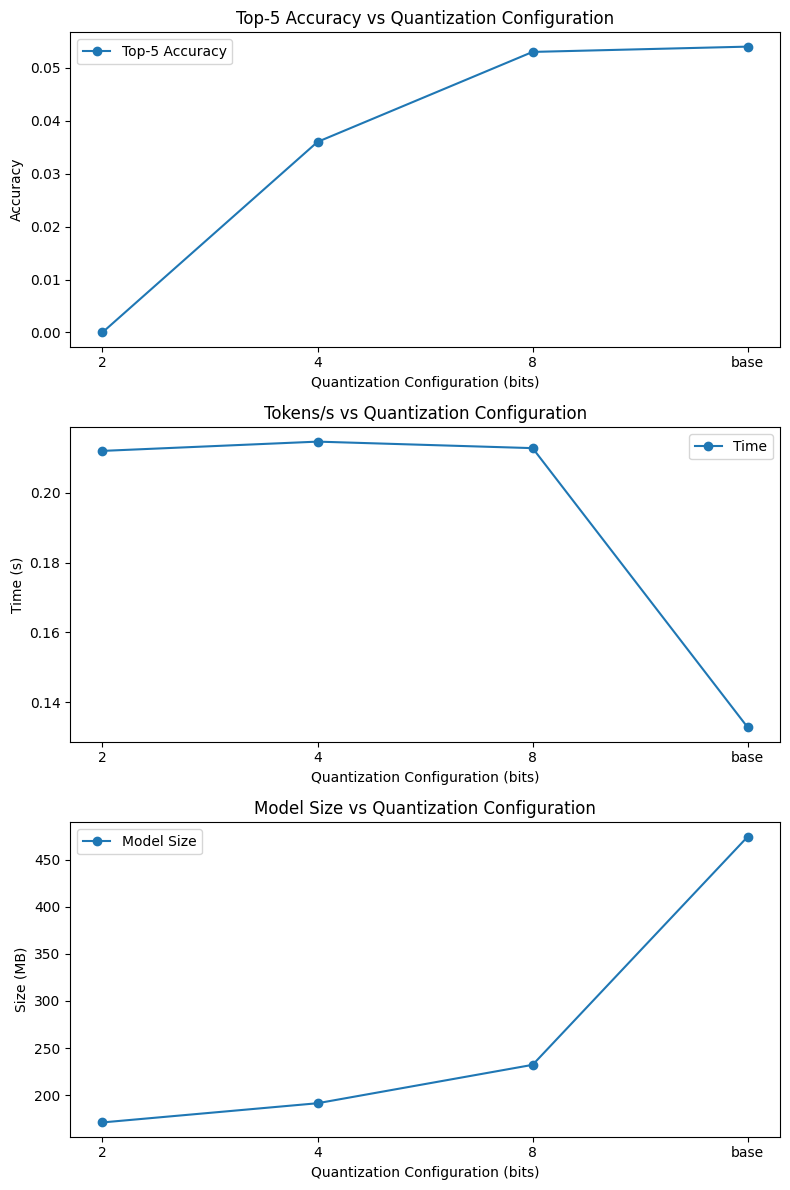

In [9]:
import matplotlib.pyplot as plt

# Quantization configurations
quant_configs = [2, 4, 8, "base"]

# Lists to store results
accuracies = [accuracy2, accuracy4, accuracy8, accuracy]
times = [1/time2, 1/time4, 1/time8, 1/time0]
sizes = [os.path.getsize('opt-125m-2bit-128g/gptq_model-2bit-128g.safetensors') / (1024**2), os.path.getsize('opt-125m-4bit-128g/gptq_model-4bit-128g.safetensors') / (1024**2), os.path.getsize('opt-125m-8bit-128g/gptq_model-8bit-128g.safetensors') / (1024**2), os.path.getsize('opt-125m-128g/model.safetensors') / (1024**2)]

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plotting Accuracy
ax1.plot(quant_configs, accuracies, marker='o', label='Top-5 Accuracy')
ax1.set_title('Top-5 Accuracy vs Quantization Configuration')
ax1.set_xlabel('Quantization Configuration (bits)')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting Time
ax2.plot(quant_configs, times, marker='o', label='Time')
ax2.set_title('Sec/token vs Quantization Configuration')
ax2.set_xlabel('Quantization Configuration (bits)')
ax2.set_ylabel('N tokens')
ax2.legend()

# Plotting Size
ax3.plot(quant_configs, sizes, marker='o', label='Model Size')
ax3.set_title('Model Size vs Quantization Configuration')
ax3.set_xlabel('Quantization Configuration (bits)')
ax3.set_ylabel('Size (MB)')
ax3.legend()

plt.tight_layout()
plt.show()